# Exercise 2

## Importing requried libraries

In [1]:
# Import necessary libraries
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import os
import pandas as pd

#RegEx
import re


#For visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Important classifciation metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report

# For RNN training and validation

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Reshape, Flatten
from tensorflow.keras.models import load_model

## Definiing functions to read the data from the train/test folder

In [2]:
def get_lan(folder_p,parent_folder):
  #parent_folder='/content/drive/MyDrive/Deep Learning/Final Project/data/train/'
  lang=folder_p.replace(parent_folder,"")
  return lang

In [3]:
#Function created to read the scripts from folder [folder]
def read_files(folder):
    data=pd.DataFrame(columns=['Code','Language'])
    directory_list = list()
    for root, dirs, files in os.walk(folder, topdown=False):
        for name in dirs:
            directory_list.append(os.path.join(root, name))
    for folder_nm in directory_list:
      for file_nm in os.listdir(folder_nm):
        fnm=folder_nm + '/' + file_nm
        with open(fnm, 'r') as file:
            # Read the entire file content
            content = file.read()
            lan=get_lan(folder_nm,folder + '/')
            temp=pd.DataFrame({'Code':[content],'Language':[lan]})
            data=pd.concat([data,temp],ignore_index=True)
    return data

## Reading the scripts from the train and test folders

In [4]:
#Read each train script and save the content in a df
df_train=read_files("/content/drive/MyDrive/Deep Learning/Final Project/data/train")

In [5]:
#Read each test script and save the content in a df
df_test=read_files("/content/drive/MyDrive/Deep Learning/Final Project/data/test")

In [6]:
df_train.shape
df_train['bucket']='train'

In [7]:
df_test.shape
df_test['bucket']='test'

## Let's concatenate both datasets

In [8]:
df=pd.concat([df_train,df_test],ignore_index=True)

## Let's perform some data exploration

In [147]:
#Confirming the distribution of instances by target
df['Language'].value_counts()

Language
Java          100
JavaScript    100
D             100
Python        100
C++           100
Rust          100
PHP           100
Haskell       100
C#            100
C             100
Name: count, dtype: int64

In [10]:
codes = df["Code"].apply(lambda x: len(str(x).split()))

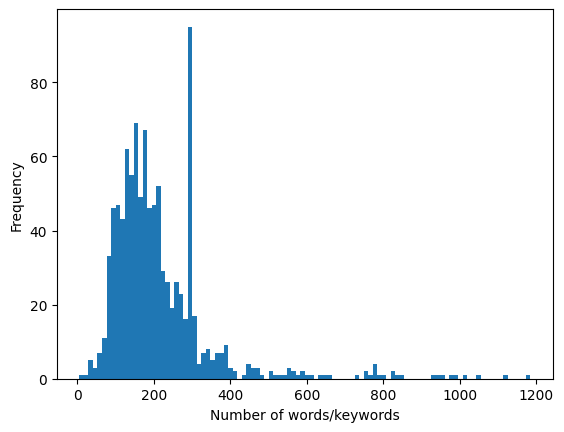

In [11]:
codes.plot.hist(bins=100)
plt.xlabel("Number of words/keywords")
plt.show()

## Let's clean the code removing non-english characters

In [146]:
#Function to clean any text written in different language (non English)
def clean_text(text):
    # This regex matches any character that is not an English letter, digit, or common punctuation
    cleaned_text = re.sub(r'[^a-zA-Z0-9\s,.!?\'"-]', '', text)
    return cleaned_text

In [13]:
df['Code_clean']=df['Code'].apply(lambda x: clean_text(x))

In [14]:
codes_cleaned = df["Code_clean"].apply(lambda x: len(str(x).split()))

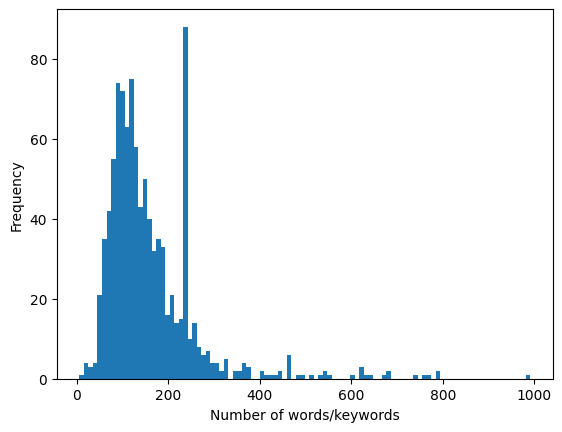

In [15]:
codes_cleaned.plot.hist(bins=100)
plt.xlabel("Number of words/keywords")
plt.show()

In [16]:
codes_cleaned.describe()

count    1000.000000
mean      161.052000
std       105.801253
min         6.000000
25%        96.000000
50%       133.000000
75%       197.500000
max       991.000000
Name: Code_clean, dtype: float64

In [17]:
p = 0.9
print(f"The {100*p:.0f}% of the codes have {codes_cleaned.quantile(p):.0f} words/keywords")

The 90% of the codes have 250 words/keywords


In [18]:
codes_train = df[df['bucket']=='train']['Code_clean'].to_list()

In [19]:
codes_test=df[df['bucket']=='test']['Code_clean'].to_list()

In [20]:
#Function to convert the target variable to numeric
def target(language):
  if language=='Java':
    target=0
  elif language=='JavaScript':
    target=1
  elif language=='D':
    target=2
  elif language=='Python':
    target=3
  elif language=='C++':
    target=4
  elif language=='Rust':
    target=5
  elif language=='PHP':
    target=6
  elif language=='Haskell':
    target=7
  elif language=='C#':
    target=8
  elif language=='C':
    target=9
  return target

In [21]:
df['target']=df['Language'].apply(lambda x: target(x))

In [22]:
df['target'].value_counts()

target
0    100
1    100
2    100
3    100
4    100
5    100
6    100
7    100
8    100
9    100
Name: count, dtype: int64

In [23]:
y_test=df[df['bucket']=='test']['target'].to_numpy()

In [24]:
y_train=df[df['bucket']=='train']['target'].to_numpy()

## Creating the vocabulary and the bag of words

In [25]:
# Step 2: Tokenization
tokenized_codes = [word_tokenize(doc) for doc in codes_train]

In [26]:
# Step 3: Removing stop words
stop_words = set(stopwords.words('english'))
filtered_codes = [[word for word in doc if word not in stop_words] for doc in tokenized_codes]

In [27]:
# Step 4: Flatten the tokenized docs back into sentences
flattened_codes = [' '.join(doc) for doc in filtered_codes]

In [28]:
# Step 5: Create the Bag of Words model
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(flattened_codes)

In [29]:
# Convert to an array to see the result
bow_array = X.toarray()

In [30]:
# Get the vocabulary
vocabulary = vectorizer.get_feature_names_out()

In [31]:
print("Vocabulary:", vocabulary)
print("Bag of Words Array:\n", bow_array)

Vocabulary: ['00' '000' '0000' ... 'zx' 'zxs' 'zzs']
Bag of Words Array:
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [32]:
bow_array[1].shape

(12402,)

## Training neural network

In [33]:
bow_array = bow_array.reshape((900,12402))

In [89]:
# Define the input shape
input_shape = (12402, 1)  # Input shape is (12402, 1)

# Create the neural network model
model = Sequential()
model.add(Flatten(input_shape=input_shape))  # Flatten the input
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))

#Learning rate
learning_rate=0.00001

# Compile the model
model.compile(optimizer=tf.optimizers.Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 12402)             0         
                                                                 
 dense_8 (Dense)             (None, 256)               3175168   
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 10)                650       
                                                                 
Total params: 3216970 (12.27 MB)
Trainable params: 3216970 (12.27 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [35]:
# Ensure y_train is one-hot encoded
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=10)

In [90]:
b_s=8

In [91]:
# Train the model
trained_model = model.fit(bow_array, y_train_one_hot, epochs=20, batch_size=b_s, validation_split=0.2,shuffle=True)

Epoch 1/20
90/90 [==============================] - 2s 6ms/step - loss: 2.2544 - accuracy: 0.1514 - val_loss: 2.3927 - val_accuracy: 0.0000e+00
Epoch 2/20
90/90 [==============================] - 0s 4ms/step - loss: 2.1204 - accuracy: 0.3167 - val_loss: 2.4294 - val_accuracy: 0.0000e+00
Epoch 3/20
90/90 [==============================] - 0s 4ms/step - loss: 1.9924 - accuracy: 0.4806 - val_loss: 2.4714 - val_accuracy: 0.0000e+00
Epoch 4/20
90/90 [==============================] - 0s 4ms/step - loss: 1.8643 - accuracy: 0.6042 - val_loss: 2.5210 - val_accuracy: 0.0000e+00
Epoch 5/20
90/90 [==============================] - 0s 4ms/step - loss: 1.7342 - accuracy: 0.7681 - val_loss: 2.5808 - val_accuracy: 0.0000e+00
Epoch 6/20
90/90 [==============================] - 0s 4ms/step - loss: 1.6018 - accuracy: 0.8694 - val_loss: 2.6492 - val_accuracy: 0.0000e+00
Epoch 7/20
90/90 [==============================] - 0s 4ms/step - loss: 1.4690 - accuracy: 0.9125 - val_loss: 2.7257 - val_accuracy: 0.0

In [150]:
model.save('/content/drive/MyDrive/Deep Learning/Final Project/model_05232024_' + str(learning_rate)+ '_' + str(b_s) +'.h5')

## Let's create the bag of words of the test data

In [92]:
#Tokenizing the test codes
tokenized_test_codes = [word_tokenize(doc) for doc in codes_test]

In [93]:
#Removing stop words from test codes
filtered_test_codes = [[word for word in doc if word not in stop_words] for doc in tokenized_test_codes]

In [94]:
#Flatten the tokenized docs back into sentences
flattened_test_codes = [' '.join(doc) for doc in filtered_test_codes]

In [95]:
vectorizer_test = CountVectorizer(vocabulary=vocabulary)

In [96]:
#Bag of words
X_test = vectorizer_test.transform(flattened_test_codes)

In [97]:
# Convert to an array to see the result
bow_array_test = X_test.toarray()

In [98]:
bow_array_test.shape

(100, 12402)

## Now let's use the model to perform some predictions

In [99]:
predictions=model.predict(bow_array_test)

4/4 [==============================] - 0s 3ms/step


In [100]:
predictions.shape

(100, 10)

In [101]:
predictions_categories=[]

In [102]:
for pred in predictions:
  index_max = np.argmax(pred)
  predictions_categories.append(index_max)

In [103]:
predictions_categories=np.array(predictions_categories)

## Let's check the accuracy

In [104]:
cm=confusion_matrix(y_test,predictions_categories)

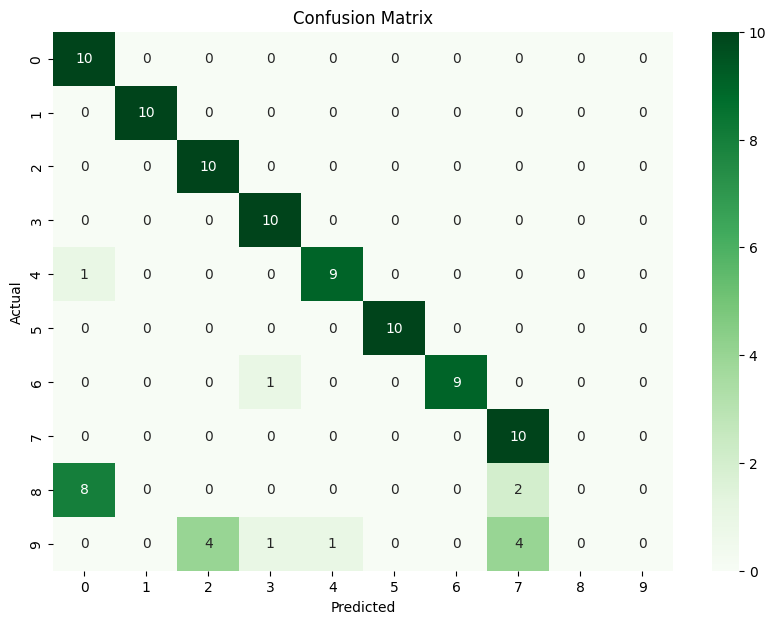

In [105]:
# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [106]:
# Calculate accuracy
accuracy = accuracy_score(y_test, predictions_categories)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.78


In [148]:
#Saving the model
#model.save('/content/drive/MyDrive/Deep Learning/Final Project/model_alt_05232024_' + str(learning_rate)+ '_' + str(b_s) +'.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Alternative approach

In [54]:
tokenized_codes_alt = [word_tokenize(doc) for doc in codes_train]

In [63]:
#Removing stop words
stop_words_alt = set('')
filtered_codes_alt = [[word for word in doc if word not in stop_words_alt] for doc in tokenized_codes_alt]

In [64]:
#Flatten the tokenized docs back into sentences
flattened_codes_alt = [' '.join(doc) for doc in filtered_codes_alt]

In [65]:
#Create the Bag of Words model
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(flattened_codes_alt)

In [66]:
# Convert to an array to see the result
bow_array_alt = X.toarray()

In [67]:
# Get the vocabulary
vocabulary_alt = vectorizer.get_feature_names_out()

In [68]:
bow_array_alt[0].shape

(12432,)

In [69]:
bow_array_alt.shape

(900, 12432)

## Training alternative model (considering stop words as they might be part of binary operators in some of the programming languages)

In [70]:
bow_array_alt = bow_array_alt.reshape((900,12432))

In [128]:
# Define the input shape
input_shape_alt = (12432, 1)  # Input shape is (12402, 1)

# Create the neural network model
model_alt = Sequential()
model_alt.add(Flatten(input_shape=input_shape_alt))  # Flatten the input
model_alt.add(Dense(256, activation='relu'))
model_alt.add(Dense(128, activation='relu'))
model_alt.add(Dense(64, activation='relu'))
model_alt.add(Dense(10, activation='softmax'))

#Learning rate
learning_rate_alt=0.00001

# Compile the model
model_alt.compile(optimizer=tf.optimizers.Adam(learning_rate_alt), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model_alt.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 12432)             0         
                                                                 
 dense_20 (Dense)            (None, 256)               3182848   
                                                                 
 dense_21 (Dense)            (None, 128)               32896     
                                                                 
 dense_22 (Dense)            (None, 64)                8256      
                                                                 
 dense_23 (Dense)            (None, 10)                650       
                                                                 
Total params: 3224650 (12.30 MB)
Trainable params: 3224650 (12.30 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [126]:
batch_s=8

In [129]:
# Train the model
trained_model_alt = model_alt.fit(bow_array_alt, y_train_one_hot, epochs=25, batch_size=batch_s, validation_split=0.2,shuffle=True)

Epoch 1/25
90/90 [==============================] - 2s 6ms/step - loss: 2.2976 - accuracy: 0.0764 - val_loss: 2.2843 - val_accuracy: 0.2222
Epoch 2/25
90/90 [==============================] - 0s 4ms/step - loss: 2.1682 - accuracy: 0.3736 - val_loss: 2.3143 - val_accuracy: 0.1722
Epoch 3/25
90/90 [==============================] - 0s 4ms/step - loss: 2.0594 - accuracy: 0.5278 - val_loss: 2.3449 - val_accuracy: 0.1167
Epoch 4/25
90/90 [==============================] - 0s 4ms/step - loss: 1.9516 - accuracy: 0.7056 - val_loss: 2.3757 - val_accuracy: 0.0944
Epoch 5/25
90/90 [==============================] - 0s 4ms/step - loss: 1.8363 - accuracy: 0.8014 - val_loss: 2.4095 - val_accuracy: 0.0667
Epoch 6/25
90/90 [==============================] - 0s 4ms/step - loss: 1.7128 - accuracy: 0.8681 - val_loss: 2.4449 - val_accuracy: 0.0333
Epoch 7/25
90/90 [==============================] - 0s 4ms/step - loss: 1.5780 - accuracy: 0.9125 - val_loss: 2.4850 - val_accuracy: 0.0222
Epoch 8/25
90/90 [==

## Creating BOW with the new vetorizer

In [130]:
#Tokenizing the test codes
tokenized_test_codes_alt = [word_tokenize(doc) for doc in codes_test]

In [131]:
#Removing stop words from test codes
filtered_test_codes_alt = [[word for word in doc if word not in stop_words_alt] for doc in tokenized_test_codes_alt]

In [132]:
#Flatten the tokenized docs back into sentences
flattened_test_codes_alt = [' '.join(doc) for doc in filtered_test_codes_alt]

In [133]:
vectorizer_test_alt = CountVectorizer(vocabulary=vocabulary_alt)

In [134]:
#Bag of words
X_test_alt = vectorizer_test_alt.transform(flattened_test_codes_alt)

In [135]:
# Convert to an array to see the result
bow_array_test_alt = X_test_alt.toarray()

In [136]:
bow_array_test_alt.shape

(100, 12432)

## Making predictions with the alternative model

In [137]:
predictions_alt=model_alt.predict(bow_array_test_alt)

4/4 [==============================] - 0s 3ms/step


In [138]:
predictions_categories_alt=[]

In [139]:
for pred in predictions_alt:
  index_max = np.argmax(pred)
  predictions_categories_alt.append(index_max)

In [140]:
predictions_categories_alt=np.array(predictions_categories_alt)

## Let's check the accuracy of the alternative model

In [141]:
cm_alt=confusion_matrix(y_test,predictions_categories_alt)

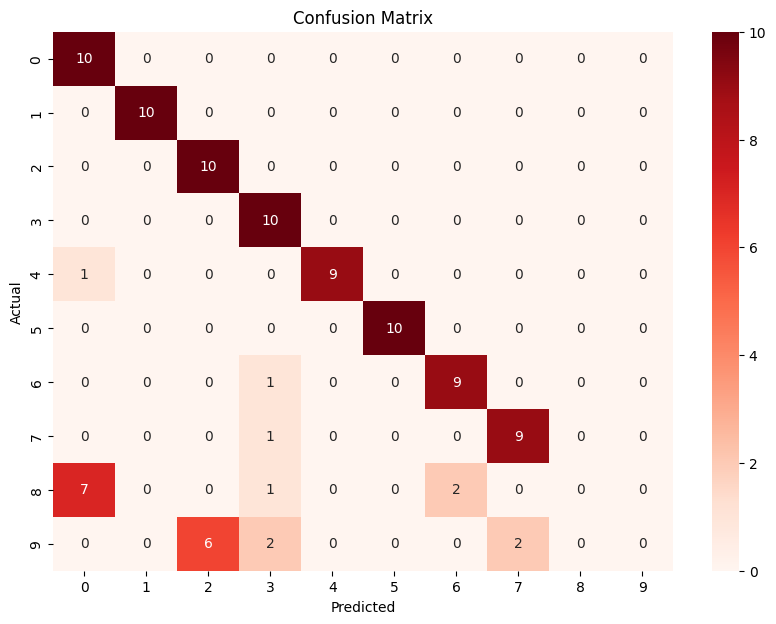

In [142]:
# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_alt, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [143]:
# Calculate accuracy
accuracy_alt = accuracy_score(y_test, predictions_categories_alt)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.78


In [149]:
#model_alt.save('/content/drive/MyDrive/Deep Learning/Final Project/model_alt_05232024_' + str(learning_rate_alt)+ '_' + str(batch_s) +'.h5')

 Conclusions:

 - Both models work really in 8 of the 10 classes, C# & C have a high rate of miss-classificiation.

 - We could try a different method of tokenization to be able to capture the pattern of codes C# and C.

 - The accuracies shared in the documents were obtain after several adjustements to batch sizes and learning rates.